## Data Overview

In [1]:
# import libraries
import torch
import cv2
import os
import time
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import ConvTranspose3d, Conv3d, MaxPool3d
from torch.nn import BCEWithLogitsLoss, Module, ModuleList, ReLU
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from torchvision.transforms import CenterCrop
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from pathlib import Path
from imutils import paths
from tqdm import tqdm
from PIL import Image as im

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
# set the RNG
random.seed(777)

In [3]:
# base path of the dataset
DATASET_PATH = 'F:/Medical_DATA/MosMedData/'

In [4]:
# define the path to the images and masks dataset
IMAGE_DATASET_NII_PATH = DATASET_PATH + 'images_nii/'
MASK_DATASET_NII_PATH = DATASET_PATH + 'masks_nii/'

IMAGE_DATASET_PNG_PATH = DATASET_PATH + 'images_png/'
MASK_DATASET_PNG_PATH = DATASET_PATH + 'masks_png/'

In [5]:
# define the test split
TEST_SPLIT = 0.15

In [6]:
# determine the device to be used for training and evaluation
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# determine if there will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == 'cuda' else False

In [8]:
# load "study" image from path
scan = nib.load(IMAGE_DATASET_NII_PATH + 'study_0255.nii')
scan_arr = scan.get_fdata()
scan_arr_shape = scan_arr.shape
print(scan_arr_shape)

(512, 512, 38)


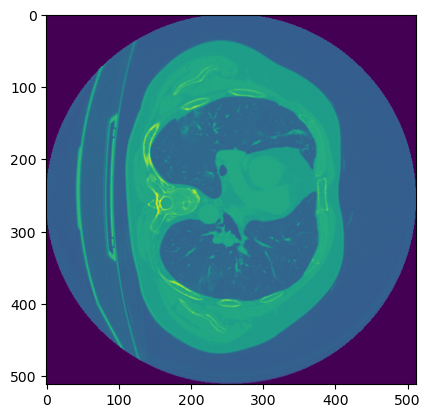

In [9]:
# plotting "study" image
scan_20 = scan_arr[:, :, 20]
plt.imshow(scan_20)
plt.show()

In [10]:
# load metadata (scan header)
scan_header = scan.header
print(scan_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  38   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.     0.923  0.923  8.     0.     0.     0.     0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Time=234114.350'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 222.194
qoffset_y       : -235.78648
qoffset_z       : -

In [11]:
# load "mask" image from path
mask = nib.load(MASK_DATASET_NII_PATH + 'study_0255_mask.nii')
mask_arr = mask.get_fdata()
mask_arr_shape = mask_arr.shape
print(mask_arr_shape)

(512, 512, 38)


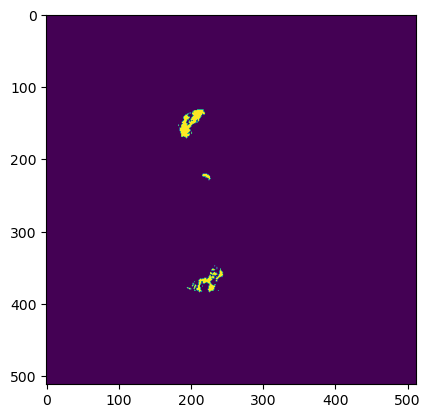

In [12]:
# plotting "mask" image
mask_20 = mask_arr[:, :, 20]
plt.imshow(mask_20)
plt.show()

In [13]:
# load metadata (mask header)
mask_header = mask.header
print(mask_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512  38   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.     0.923  0.923  8.     0.     0.     0.     0.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'Time=234114.350'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 222.194
qoffset_y       : -235.78648
qoffset_z       : -

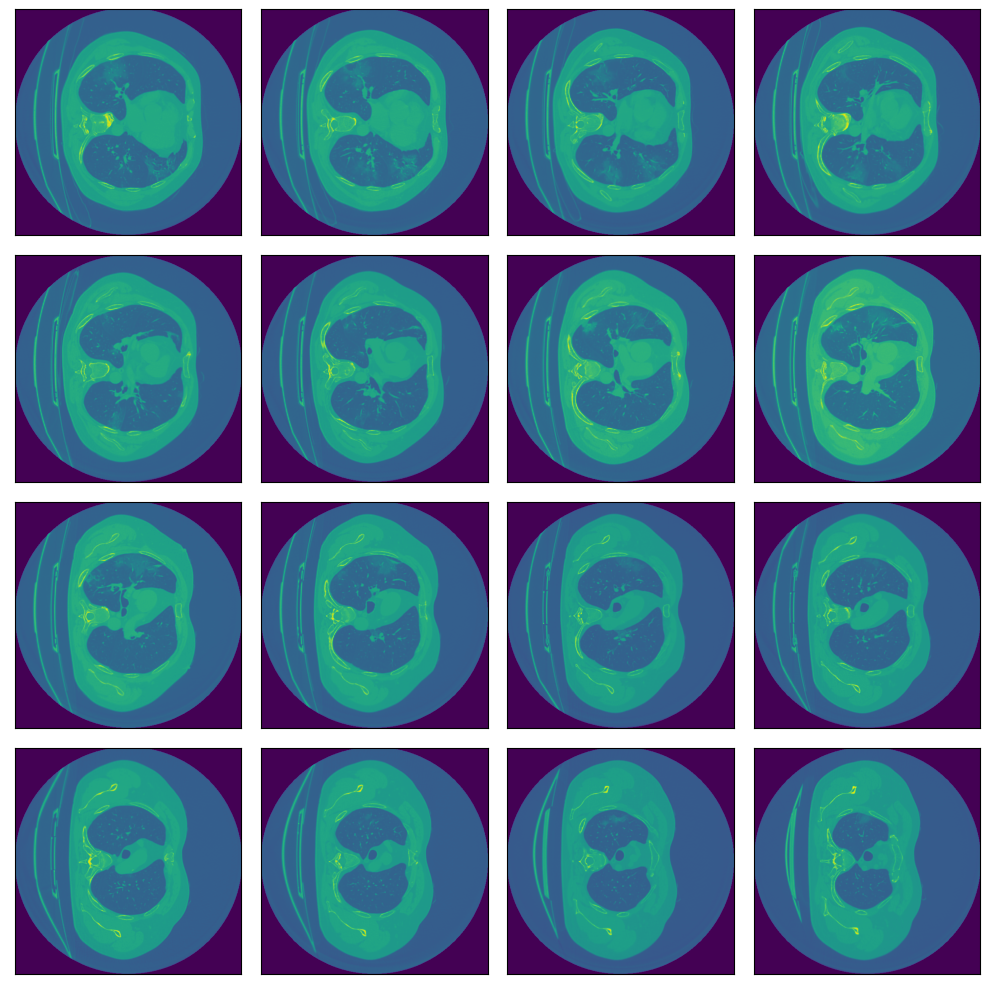

In [14]:
# print out "study" images from dataset
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(scan_arr[:, :, i + 15])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

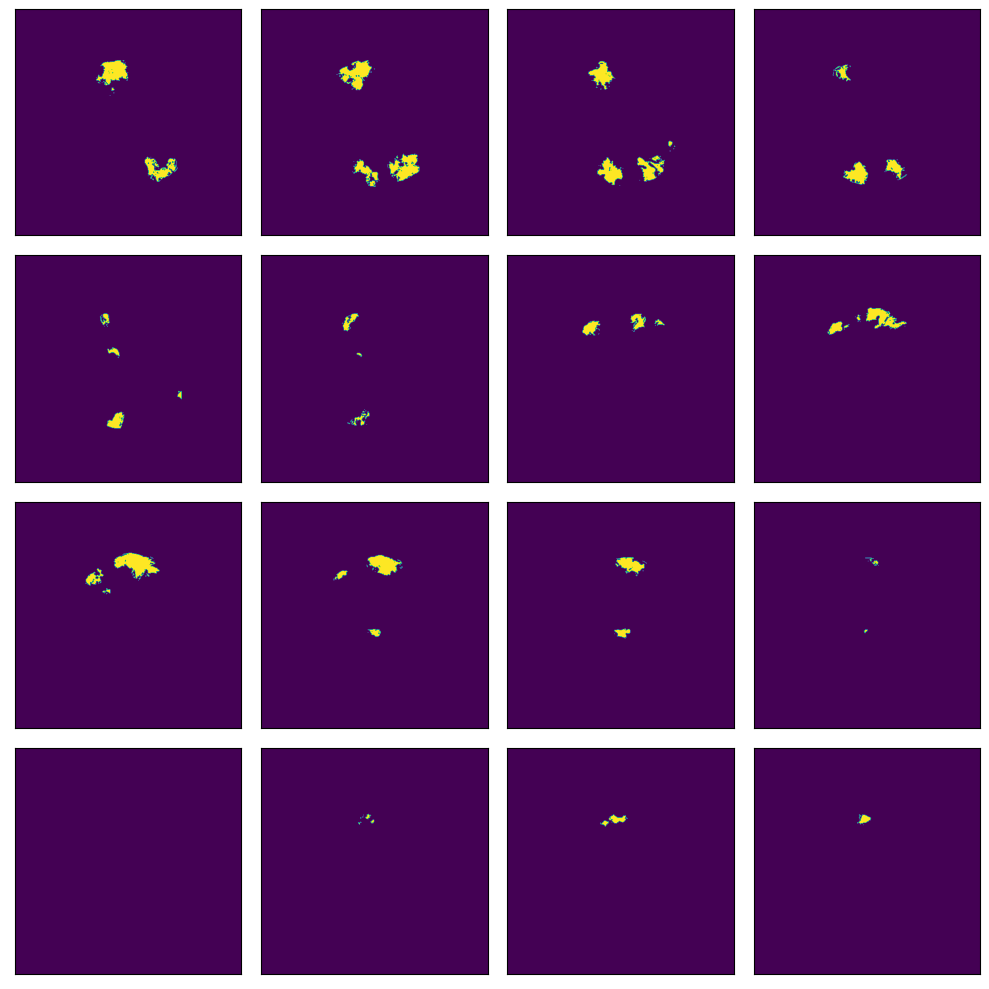

In [15]:
# print out "mask" images from dataset
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(mask_arr[:, :, i + 15])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

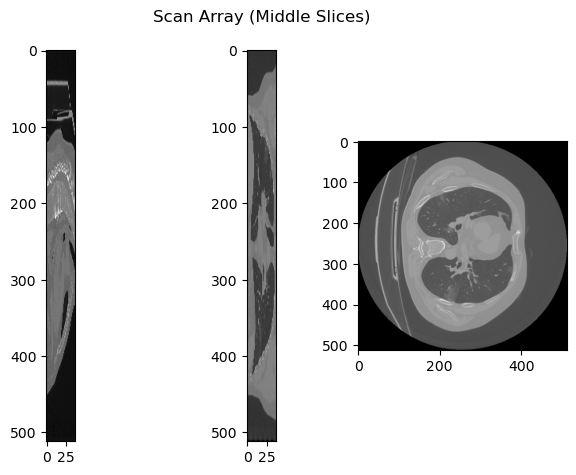

In [16]:
# display scan array's middle slices
fig, axs = plt.subplots(1, 3)
fig.suptitle('Scan Array (Middle Slices)')
axs[0].imshow(scan_arr[scan_arr_shape[0] // 2, :, :], cmap='gray')
axs[1].imshow(scan_arr[:, scan_arr_shape[1] // 2, :], cmap='gray')
axs[2].imshow(scan_arr[:, :, scan_arr_shape[2] // 2], cmap='gray')
fig.tight_layout()
plt.show()

#### Formulas for aspect ratio
r = w / h\
1.3 * w = h\
r = w / h = 1 / 1.3 = 0.77 

In [17]:
# calculate proper aspect ratios
pix_dim = scan_header['pixdim'][1:4]
aspect_ratios = [pix_dim[1] / pix_dim[2], pix_dim[0] / pix_dim[2], pix_dim[0] / pix_dim[1]]
print('The required aspect ratios: ', aspect_ratios)

The required aspect ratios:  [0.115375, 0.115375, 1.0]


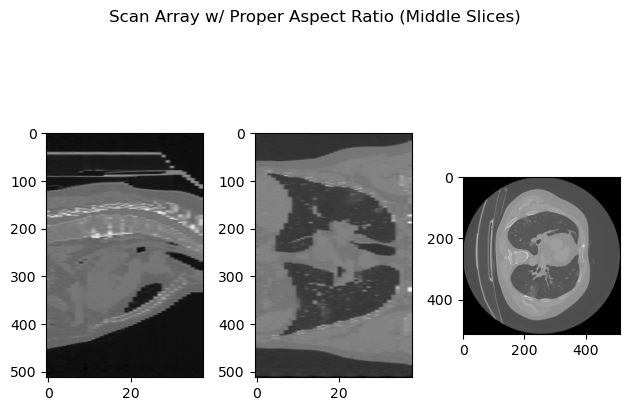

In [18]:
# display scan array's middle slices with proper aspect ratio
fig, axs = plt.subplots(1, 3)
fig.suptitle('Scan Array w/ Proper Aspect Ratio (Middle Slices)')
axs[0].imshow(scan_arr[scan_arr_shape[0] // 2, :, :], aspect=aspect_ratios[0], cmap='gray')
axs[1].imshow(scan_arr[:, scan_arr_shape[1] // 2, :], aspect=aspect_ratios[1], cmap='gray')
axs[2].imshow(scan_arr[:, :, scan_arr_shape[2] // 2], aspect=aspect_ratios[2], cmap='gray')
fig.tight_layout()
plt.show()

## Data pre-processing

In [19]:
# iterate over files in the given directory
def filepaths(folder_dir):
    lst = []
    image_paths = Path(folder_dir).glob('*.nii')
    for img in image_paths:
        lst.append(img)
    return lst    

In [20]:
# load the image and mask filepaths in a sorted manner
image3D_paths = sorted(filepaths(IMAGE_DATASET_NII_PATH))
mask3D_paths = sorted(filepaths(MASK_DATASET_NII_PATH))

In [21]:
# print out image paths
image3D_paths[:5]

[WindowsPath('F:/Medical_DATA/MosMedData/images_nii/study_0255.nii'),
 WindowsPath('F:/Medical_DATA/MosMedData/images_nii/study_0256.nii'),
 WindowsPath('F:/Medical_DATA/MosMedData/images_nii/study_0257.nii'),
 WindowsPath('F:/Medical_DATA/MosMedData/images_nii/study_0258.nii'),
 WindowsPath('F:/Medical_DATA/MosMedData/images_nii/study_0259.nii')]

In [22]:
# calculate new image dimensions from aspect ratio
new_scan_dims = np.multiply(scan_arr_shape, pix_dim)
new_scan_dims = (round(new_scan_dims[0]), round(new_scan_dims[1]), round(new_scan_dims[2]))
print('The new scan dimensions: ', new_scan_dims)

The new scan dimensions:  (473, 473, 304)


In [24]:
# convert 3D NIfTI (.nii) into 2D png
def imgConverter(img3D_paths, img3D_folder, img2D_folder):
    if len(os.listdir(img2D_folder)) == 0:
        
        # iterate over all image paths
        for img3D_path in img3D_paths:
            # parse the path
            img_name = str(img3D_path)[-14:]
            
            # load images from path
            scan = nib.load(img3D_folder + img_name)
            scan_arr = scan.get_fdata()
            scan_arr_shape = scan_arr.shape

            # iterate and save scan slices along 0th dimension
            for i in range(scan_arr_shape[0]):
                # resample the slice
                output_arr = cv2.resize(scan_arr[i, :, :], (new_scan_dims[2], new_scan_dims[1]))
                
                # save the slice as .png image
                cv2.imwrite(img2D_folder + f'/{img_name[:-4]}_Dim0_Slice' + str(i) + '.png', output_arr)
            
            # iterate and save scan slices along 1st dimension
            for i in range(scan_arr_shape[1]):
                # resample the slice
                output_arr = cv2.resize(scan_arr[:, i, :], (new_scan_dims[2], new_scan_dims[0]))
                
                # save the slice as .png image
                cv2.imwrite(img2D_folder + f'/{img_name[:-4]}_Dim1_Slice' + str(i) + '.png', output_arr)
            
            # iterate and save scan slices along 2nd dimension
            for i in range(scan_arr_shape[2]):
                # resample the slice                
                output_arr = cv2.resize(scan_arr[:, :, i], (new_scan_dims[1], new_scan_dims[0]))
                
                # rotate slice clockwise 90 degrees
                output_arr = cv2.rotate(output_arr, cv2.ROTATE_90_CLOCKWISE)
                
                # save the slice as .png image
                cv2.imwrite(img2D_folder + f'/{img_name[:-4]}_Dim2_Slice' + str(i) + '.png', output_arr)

In [1]:
# convert 3D images
imgConverter(image3D_paths, IMAGE_DATASET_NII_PATH, IMAGE_DATASET_PNG_PATH)

In [ ]:
# convert 3D masks
imgConverter(mask3D_paths, MASK_DATASET_NII_PATH, MASK_DATASET_PNG_PATH)

## U-Net Architecture

In [16]:
# PyTorch U-Net
Image(url='https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12859-020-03943-2/MediaObjects/12859_2020_3943_Fig5_HTML.png?as=webp', 
      width=900, height=550
)

In [18]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 4

In [19]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 16

In [20]:
# define the input image dimensions
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

In [21]:
# define threshold to filter weak predictions
THRESHOLD = 0.5

In [22]:
# define the path to the base output directory
BASE_OUTPUT = 'C:/BigDataProjects/CV/ImageSegmentation/-image-segmentation/'

In [23]:
# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = BASE_OUTPUT + 'unet_covid.pth'
PLOT_PATH = BASE_OUTPUT + 'plot.png'
TEST_PATHS = BASE_OUTPUT + 'test_paths.txt'

In [24]:
# create custom segmentation dataset class
class SegmentationDataset(Dataset):
	def __init__(self, image_paths, mask_paths, transforms):
		
        # store the image and mask filepaths, and augmentation transforms
		self.image_paths = image_paths
		self.mask_paths = mask_paths
		self.transforms = transforms
	
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.image_paths)
	
	def __getitem__(self, idx):
		# grab the image and mask path from the current index
		image_path = self.image_paths[idx]
		mask_path = self.image_paths[idx]
		
		# load the image and mask from disk
		image = nib.load(image_path).get_fdata()
		mask = nib.load(mask_path).get_fdata()
		
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		
		# return a tuple of the image and its mask
		return (image, mask)
			

In [25]:
# define a block module as the building unit of encoder and decoder architecture
class Block(Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		
        # store the convolution and RELU layers
		self.conv1 = Conv2d(in_channels, out_channels, kernel_size=3)
		self.relu = ReLU()
		self.conv2 = Conv2d(out_channels, out_channels, kernel_size=3)
    
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [26]:
# encode the input image into feature representations at multiple different levels
class Encoder(Module):
	def __init__(self, channels=(3, 32, 64, 128, 256)):
		super().__init__()
		
        # store the encoder blocks and maxpooling layer
		self.enc_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)]
        )
		self.pool = MaxPool2d(kernel_size=2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		block_outputs = []
		
		# loop through the encoder blocks
		for block in self.enc_blocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			block_outputs.append(x)
			x = self.pool(x)
		
		# return the list containing the intermediate outputs
		return block_outputs

In [27]:
# take the extracted features and reconstruct a segmentation mask
class Decoder(Module):
	def __init__(self, channels=(256, 128, 64, 32)):
		super().__init__()
		
		# initialize the number of channels, upsampler blocks, and decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
			 	for i in range(len(channels) - 1)]
		)
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)]
		)
	
	def forward(self, x, enc_features):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# pass the concatenated output through the current decoder block
			enc_feat = self.crop(enc_features[i], x)
			x = torch.cat([x, enc_feat], dim=1)
			x = self.dec_blocks[i](x)
		
		# return the final decoder output
		return x
	
	def crop(self, enc_features, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		enc_features = CenterCrop([H, W])(enc_features)
		
		# return the cropped features
		return enc_features

In [28]:
# build U-Net model class
class UNet(Module):
	def __init__(self, enc_channels=(3, 32, 64, 128, 256),
				 dec_channels=(256, 128, 64, 32),
				 nb_classes=1, retain_dim=True,
				 out_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
		
		super().__init__()
		
		# initialize the encoder and decoder
		self.encoder = Encoder(enc_channels)
		self.decoder = Decoder(dec_channels)
		
		# initialize the regression head and store the class variables
		self.head = Conv2d(dec_channels[-1], nb_classes, kernel_size=1)
		self.retain_dim = retain_dim
		self.out_size = out_size

	def forward(self, x):
		# grab the features from the encoder
		enc_features = self.encoder(x)
		
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		dec_features = self.decoder(enc_features[::-1][0], enc_features[::-1][1:])
		
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(dec_features)
		
		# check to see if there is retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retain_dim:
			map = F.interpolate(map, self.out_size)
		
		# return the segmentation map
		return map

## Training Segmentation Model

In [44]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(
    image_paths, 
    mask_paths, 
    test_size=TEST_SPLIT, 
    random_state=777
)

In [45]:
# unpack the data split
(train_images, test_images) = split[:2]
(train_masks, test_masks) = split[2:]

In [ ]:
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print('[INFO] saving testing image paths...')
f = open(TEST_PATHS, 'w')
f.write('\n'.join(test_images))
f.close()

In [ ]:
# define transformations
transforms = transforms.Compose(
    [transforms.ToPILImage(),
 	transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
	transforms.ToTensor()]
)

In [ ]:
# create the train and test datasets
train_data = SegmentationDataset(
    imagePaths=trainImages, 
    maskPaths=trainMasks, 
    transforms=transforms
)

test_data = SegmentationDataset(
    imagePaths=testImages, 
    maskPaths=testMasks, 
    transforms=transforms
)

print(f"[INFO] found {len(train_data)} examples in the training set...")
print(f"[INFO] found {len(test_data)} examples in the test set...")

In [ ]:
# create the training and test data loaders
train_loader = DataLoader(
	train_data, shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count()
)

test_loader = DataLoader(
	test_data, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
	num_workers=os.cpu_count()
)

In [ ]:
# initialize the UNet model
unet = UNet().to(DEVICE)

In [ ]:
# initialize loss function and optimizer
loss_func = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)

In [ ]:
# calculate steps per epoch for training and test set
train_steps = len(train_data) // BATCH_SIZE
test_steps = len(test_data) // BATCH_SIZE

In [ ]:
# initialize a dictionary to store training history
H = {'train_loss': [], 'test_loss': []}

In [ ]:
# model training
print('[INFO] training the network...')
start_time = time.time()

# loop over epochs
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	
	# initialize the total training and validation loss
	total_train_loss = 0
	total_test_loss = 0
	
	# loop over the training set
	for (i, (x, y)) in enumerate(train_loader):
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = loss_func(pred, y)
		
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		
		# add the loss to the total training loss so far
		total_train_loss += loss
	
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		
		# loop over the validation set
		for (x, y) in test_loader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			
			# make the predictions and calculate the validation loss
			pred = unet(x)
			total_testLoss += loss_func(pred, y)
	
	# calculate the average training and validation loss
	avg_train_loss = total_train_loss / train_steps
	avg_test_loss = total_test_loss / test_steps
	
	# update our training history
	H['train_loss'].append(avg_train_loss.cpu().detach().numpy())
	H['test_loss'].append(avg_test_loss.cpu().detach().numpy())
	
	# print the model training and validation information
	print('[INFO] EPOCH: {}/{}'.format(e + 1, NUM_EPOCHS))
	print('Train loss: {:.6f}, Test loss: {:.4f}'.format(avg_train_loss, avg_test_loss))

# display the total time needed to perform the training
end_time = time.time()
print('[INFO] total time taken to train the model: {:.2f}s'.format(end_time - start_time))

In [ ]:
# plot the training loss
plt.style.use('ggplot')
plt.figure()
plt.plot(H['train_loss'], label='train_loss')
plt.plot(H['test_loss'], label='test_loss')
plt.title('Training Loss on Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.savefig(PLOT_PATH)

# serialize the model to disk
torch.save(unet, MODEL_PATH)